#Introduction

This project aims to predict match score by using generalized linear model (GLM) in Turkish first division league.

Data contains 3-years match reasults (2015-2016,2016-2017, 2017-2018).

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam


In [19]:
tsl_1516 = pd.read_csv("C:/Users/Veli/Documents/R/football prediction/turkishleague/2015-2016.csv")
tsl_1617 = pd.read_csv("C:/Users/Veli/Documents/R/football prediction/turkishleague/2016-2017.csv")
tsl_1718 = pd.read_csv("C:/Users/Veli/Documents/R/football prediction/turkishleague/2017-2018.csv")
tsl=tsl_1516.append(tsl_1617)
tsl=tsl.append(tsl_1718)
tsl = tsl.dropna()
tsl = tsl[['HomeTeam','AwayTeam','FTHG','FTAG']]
tsl = tsl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
tsl.head()


,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Buyuksehyr,Bursaspor,1.0,0.0
1,Akhisar Belediyespor,Sivasspor,1.0,0.0
2,Alanyaspor,Kasimpasa,1.0,3.0
3,Genclerbirligi,Karabukspor,1.0,1.0
4,Goztep,Fenerbahce,2.0,2.0


Data frame is restricted to the columns in which we are interested. These columns,

HomeTeam= The team that is playing in the usual area that they play in
AwayTeam= The team that is playing away from home.
FTHG= Full Time Home Team Goals
FTAG= Full Time Away Team Goals

In [20]:
tsl = tsl[:-10]
tsl.mean()

HomeGoals    1.658182
AwayGoals    1.240000
dtype: float64

The home team scores more goals than away team. This can be descired as home field advantage. It's a discrete probability distribution that describes the probability of the number of scores within a match (90 mins) with a known average rate of occurrence. We know that the goals don't become more or less probable by the number of goals already scored in the match. So the number of goals is independent of time. Number of goals can be counted as  function of average rate of goals.
$$f(x)=\frac{exp^{-\lambda}\lambda^x}{x!},\quad \lambda>0$$

$\lambda$ represents the average number of goals in a match. "Home Goals" and "Away Goals" can be assumed as two independent Poisson distribution.

$P(HomeGoals>AwayGoals)$ means that home team wins the match.
$P(AwayGoals>homeGoals)$ means that away team wins the match.
$P(HomeGoals=AwayGoals)$ mean that draw.

Assumption of the independence of goals scored by each teams,$P(A\cap B)=P(A)P(B)$ let us to construct the modal easily.


##Skellam Distribution

The difference of two Poisson distributions called as Skellam distribution.
Under the condition that difference of two Poisson distributions is 0,the draw status can be computed by skellam distribution.

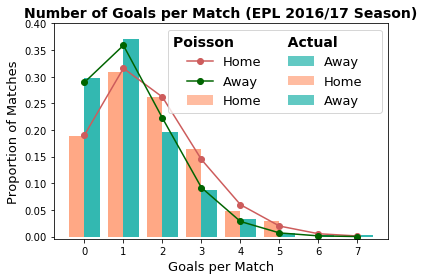

In [22]:
poisson_pred = np.column_stack([[poisson.pmf(i, tsl.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(tsl[['HomeGoals', 'AwayGoals']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],normed=True, color=["#FFA07A", "#20B2AA"])

pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (TSL 2015-2018  Sum Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()



In [24]:
# probability of draw between home and away team
skellam.pmf(0.0,  tsl.mean()[0],  tsl.mean()[1])

0.24189680197116309

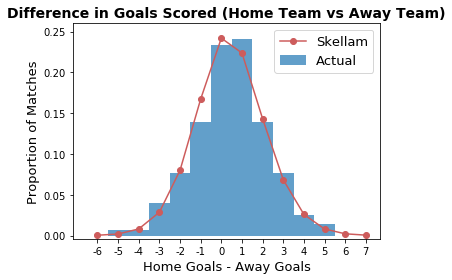

In [25]:
skellam_pred = [skellam.pmf(i,  tsl.mean()[0],  tsl.mean()[1]) for i in range(-6,8)]

plt.hist(tsl[['HomeGoals']].values - tsl[['AwayGoals']].values, range(-6,8), 
         alpha=0.7, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

#Building a Model

The result of matches is modeled  by glm with poisson family and log link function.

In [35]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([tsl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           tsl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  550
Model:                            GLM   Df Residuals:                      514
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -788.88
Date:                Wed, 26 Jun 2019   Deviance:                       553.88
Time:                        10:50:25   Pearson chi2:                     485.
No. Iterations:                     5                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.1610      0.219      0.736      0.462      -0.268       0.590
team[T.Alanyaspor]               0.2301      0.213      1.081      0.280      -0.187       0.647
team[T.Antalyaspor]             -0.0586      0.227     -0.258      0.796      -0.504       0.387
team[T.Besiktas]                 0.3587      0.208      1.727      0.084      -0.048       0.766
team[T.Bursaspor]               -0.0464      0.234     -0.198      0.843      -0.505       0.413
team[T.Buyuksehyr]               0.3545      0.207      1.713      0.087      -0.051       0.760
team[T.Fenerbahce]               0.5183      0.201      2.577      0.010       0.124       0.913
team[T.Galatasaray]              0.5530      0.199      2.780      0.005       0.163       0.943
team[T.Genclerbirligi]          -0.1363      0.232     -0.587      0.557      -0.591       0.319
team[T.Goztep]                   0.1599      0.216      0.741      0.459      -0.263       0.583
team[T.Karabukspor]             -0.7355      0.297     -2.479      0.013      -1.317      -0.154
team[T.Kasimpasa]                0.2569      0.211      1.218      0.223      -0.157       0.670
team[T.Kayserispor]             -0.0077      0.227     -0.034      0.973      -0.452       0.437
team[T.Konyaspor]               -0.1607      0.240     -0.669      0.504      -0.632       0.310
team[T.Osmanlispor]              0.0858      0.220      0.390      0.696      -0.345       0.517
team[T.Sivasspor]                0.0701      0.222      0.316      0.752      -0.364       0.505
team[T.Trabzonspor]              0.3320      0.210      1.580      0.114      -0.080       0.744
team[T.Yeni Malatyaspor]        -0.1960      0.245     -0.801      0.423      -0.676       0.284
opponent[T.Alanyaspor]           0.0888      0.195      0.455      0.649      -0.294       0.471
opponent[T.Antalyaspor]          0.0702      0.196      0.358      0.720      -0.314       0.454
opponent[T.Besiktas]            -0.5982      0.239     -2.508      0.012      -1.066      -0.131
opponent[T.Bursaspor]           -0.1197      0.211     -0.568      0.570      -0.533       0.293
opponent[T.Buyuksehyr]          -0.4467      0.231     -1.936      0.053      -0.899       0.006
opponent[T.Fenerbahce]          -0.3920      0.224     -1.749      0.080      -0.831       0.047
opponent[T.Galatasaray]         -0.3602      0.224     -1.607      0.108      -0.799       0.079
opponent[T.Genclerbirligi]      -0.0006      0.199     -0.003      0.997      -0.390       0.389
opponent[T.Goztep]              -0.0281      0.204     -0.138      0.891      -0.428       0.372
opponent[T.Karabukspor]          0.3117      0.193      1.616      0.106      -0.066       0.690
opponent[T.Kasimpasa]            0.0819      0.196      0.418      0.676      -0.302       0.466
opponent[T.Kayserispor]         -0.0574      0.201     -0.

When we examine the coefficients table, there are both positive and negative values. Similar to logistic regression, we take the exponent of the parameter values. A positive value implies more goals, while negative value that close to zero represent neutral effect.
According to coefficents table, "home" has coefficient of 0.26948 and we can say that home teams generally score more goals with $e^{0.26946}=1.34913$ times more likely  than the away teams. But this is not the same for all teams. For example, Besiktas and Fenerbahce are better scorers  than average with 0.79256 and 0.70061 parameters respectively, while Kasimpasa is worse scorer than average with -0.21928 parameter. Eventually, the _opponent_ values penalize or reward teams based on the quality of the opposition.

#Predictions

We now start making some predictions for the upcoming matches. Firstly,let us compute what is the expected average number of goals based on poisson distribution by selected teams.

In [28]:
poisson_model.predict(pd.DataFrame(data={'team': 'Besiktas', 'opponent': 'Kasimpasa',
                                       'home':1},index=[1]))

1    2.472279
dtype: float64

In [29]:
poisson_model.predict(pd.DataFrame(data={'team': 'Kasimpasa', 'opponent': 'Besiktas',
                                       'home':0},index=[1]))

1    0.83508
dtype: float64

We have two Poisson distributions. By creating a function called "sim_match" we can calculate the probability of various events.

In [30]:
def simulate_match(tsl_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = tsl_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = tsl_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
simulate_match(poisson_model, 'Besiktas', 'Kasimpasa', max_goals=3)

array([[ 0.03661273,  0.03057458,  0.01276611,  0.00355358],
       [ 0.09051688,  0.07558887,  0.03156139,  0.00878543],
       [ 0.11189149,  0.09343839,  0.03901428,  0.01086002],
       [ 0.09220899,  0.07700191,  0.03215139,  0.00894967]])

According to result matrix, rows represent the Besiktas (HomeTeam) and columns indicate the Kasimpasa (AwayTeam). 
When we analyze matrix 2 in depth , along the diagonal both teams score the same number of goals. For example, the probability of draw without scores is $P(0-0)=0.0347$, while the odds of a draw with single goal is $P(1-1)=0.0767$. So we can calculate the odds of draw by summing all  the diagonal values.

The area under the diagonal shows us the situations that Besiktas won, while the area above the diagonal shows us the situations Kasimpasa won.

It can also be calculated over 2.5 goals or below from the result matrix.


Now let us let us calculate the probability of Besiktas (HomeTeam) winning the match under the maximum of 10 goals,

In [ ]:
Now let us let us calculate the probability of Besiktas (HomeTeam) winning the match under the maximum of 10 goals,

In [31]:
bes_kas = simulate_match(poisson_model, "Besiktas", "Kasimpasa", max_goals=10)
# Besiktas win
np.sum(np.tril(bes_kas, -1))

0.73217305721444914

And the probability of Kasimpasa winning the match under the maximum of 10 goals,

In [32]:
 #Kasimpasa win
np.sum(np.triu(bes_kas, 1))

0.10634960560439147

Last, the probability of draw,

In [34]:
# draw
np.sum(np.diag(bes_kas))

0.16142144575001555